**2장 – 머신러닝 프로젝트 처음부터 끝까지 (1) **

*머신러닝 부동산 회사에 오신 것을 환영합니다! 여러분이 할 작업은 캘리포니아 지역 주택의 여러 특성을 사용해 중간 가격을 예측하는 것입니다.*


# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 데이터 가져오기

In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head(3)

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY

[3 rows x 10 columns]

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

그림 저장: attribute_histogram_plots


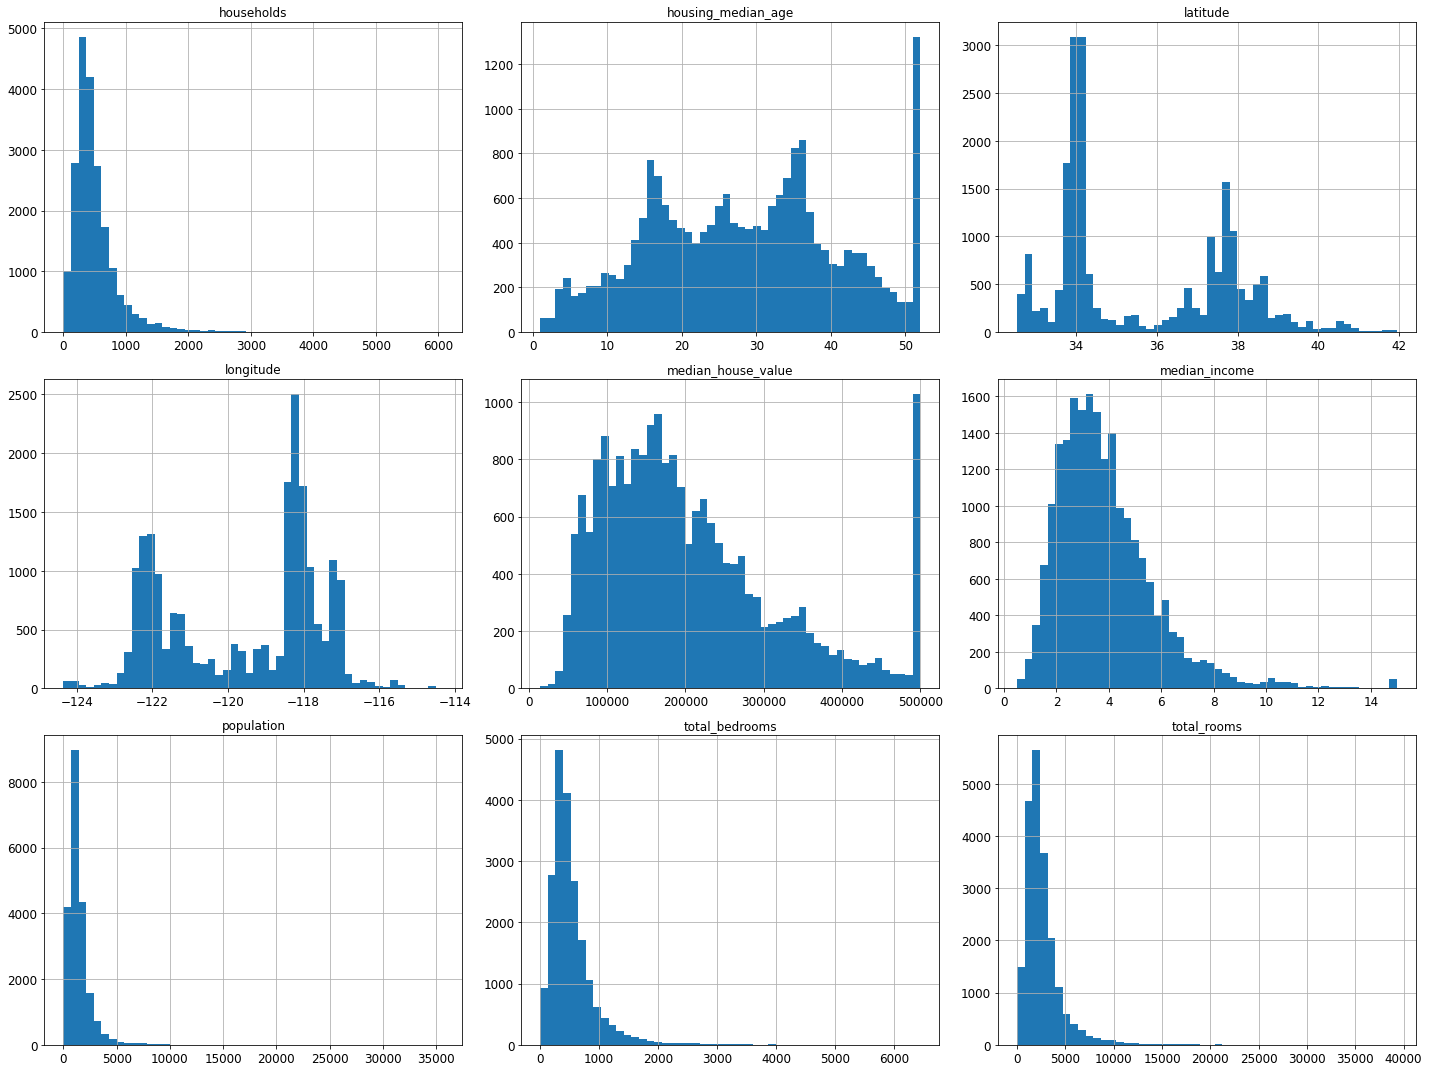

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### Train, Test 나누기

In [11]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

In [12]:
import numpy as np

# 예시로 만든 것입니다. 실전에서는 사이킷런의 train_test_split()를 사용하세요.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing, 0.2)
print('train :', len(train_set), '   test :', len(test_set))

train : 16512    test : 4128


In [15]:
test_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
20512    -121.55     38.59  ...             69600.0           INLAND
15568    -117.04     33.09  ...            335600.0        <1H OCEAN
4047     -118.51     34.14  ...            500001.0        <1H OCEAN
18127    -122.02     37.34  ...            360600.0        <1H OCEAN
3548     -118.61     34.25  ...            276600.0        <1H OCEAN

[5 rows x 10 columns]

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
test_set.tail()

longitude  latitude  ...  median_house_value  ocean_proximity
15362    -117.22     33.36  ...            263300.0        <1H OCEAN
16623    -120.83     35.36  ...            266800.0       NEAR OCEAN
18086    -122.05     37.31  ...            500001.0        <1H OCEAN
2144     -119.76     36.77  ...             72300.0           INLAND
3665     -118.37     34.22  ...            151500.0        <1H OCEAN

[5 rows x 10 columns]

### Median_income 5개 구간으로 나누어 계층적 샘플링

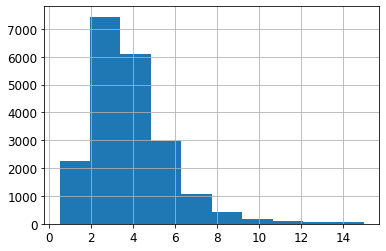

In [18]:
housing["median_income"].hist()

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 3.0, 6., np.inf],
                               labels=[1, 2, 3])

# 참고 : 옛날 코드
# housing["income_cat"] = np.ceil(housing["income_cat"] / 1.5)
# housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace="True")  # 5 이상은 5로

In [21]:
housing["income_cat"].value_counts()

2    10875
1     7403
3     2362
Name: income_cat, dtype: int64

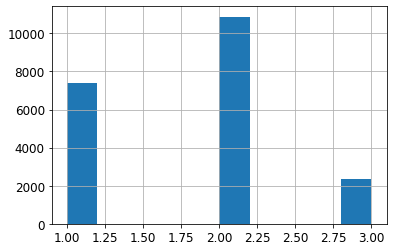

In [22]:
housing["income_cat"].hist()

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set.head()    

longitude  latitude  ...  ocean_proximity  income_cat
10266    -117.84     33.89  ...        <1H OCEAN           2
12723    -121.38     38.59  ...           INLAND           2
4264     -118.31     34.10  ...        <1H OCEAN           1
12740    -121.35     38.61  ...           INLAND           1
2787     -118.45     37.37  ...           INLAND           2

[5 rows x 11 columns]

#### - 위 코드 대신 이것을 사용해도 됨

In [24]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

strat_test_set.head()

longitude  latitude  ...  ocean_proximity  income_cat
10266    -117.84     33.89  ...        <1H OCEAN           2
12723    -121.38     38.59  ...           INLAND           2
4264     -118.31     34.10  ...        <1H OCEAN           1
12740    -121.35     38.61  ...           INLAND           1
2787     -118.45     37.37  ...           INLAND           2

[5 rows x 11 columns]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

2    0.526890
1    0.358769
3    0.114341
Name: income_cat, dtype: float64

In [26]:
housing["income_cat"].value_counts() / len(housing)

2    0.526890
1    0.358672
3    0.114438
Name: income_cat, dtype: float64

In [27]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),  # 전체에서의 비율
    "Stratified": income_cat_proportions(strat_test_set), # 계층적 샘플링한 경우
    "Random": income_cat_proportions(test_set), # 계층적 샘플링 안 한 경우 (그냥 무작위)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [28]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.358672    0.358769  0.364583      1.647981       0.027016
2  0.526890    0.526890  0.525921     -0.183908       0.000000
3  0.114438    0.114341  0.109496     -4.318374      -0.084674

In [29]:
# income_cat 특징은 더 이상 필요 없으니 지우자 : strat_train_set, strat_test_set에서...
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
strat_test_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
10266    -117.84     33.89  ...            226900.0        <1H OCEAN
12723    -121.38     38.59  ...            189400.0           INLAND
4264     -118.31     34.10  ...            350000.0        <1H OCEAN
12740    -121.35     38.61  ...            134100.0           INLAND
2787     -118.45     37.37  ...            139700.0           INLAND

[5 rows x 10 columns]

In [31]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In [32]:
strat_train_set.info()
#계층화 한 train set -> 3개의 구간으로 나눈것
# 각 구간의 범위에서 데이터를 분류해서 뽑아낸다. -> 1개의 구간에서 80%는 train 으로 20%는 test로 뽑아낸다. 
# 그냥 랜덤으로 train 과 test 뽑는것보다 오차가 훨씬 줄어든다. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 9921 to 17163
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16343 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


# <font color=red> **2장 1단계 실습 끝** </font>

# 데이터 이해를 위한 탐색과 시각화

In [ ]:
housing = strat_train_set.copy()

그림 저장: bad_visualization_plot


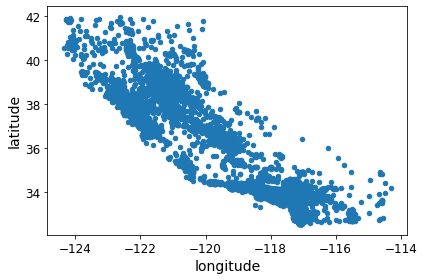

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

그림 저장: better_visualization_plot


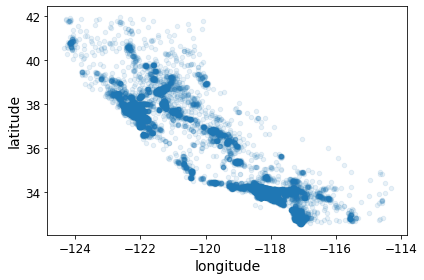

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

`sharex=False` 매개변수는 x-축의 값과 범례를 표시하지 못하는 버그를 수정합니다. 이는 임시 방편입니다(https://github.com/pandas-dev/pandas/issues/10611 참조). 수정 사항을 알려준 Wilmer Arellano에게 감사합니다.

그림 저장: housing_prices_scatterplot


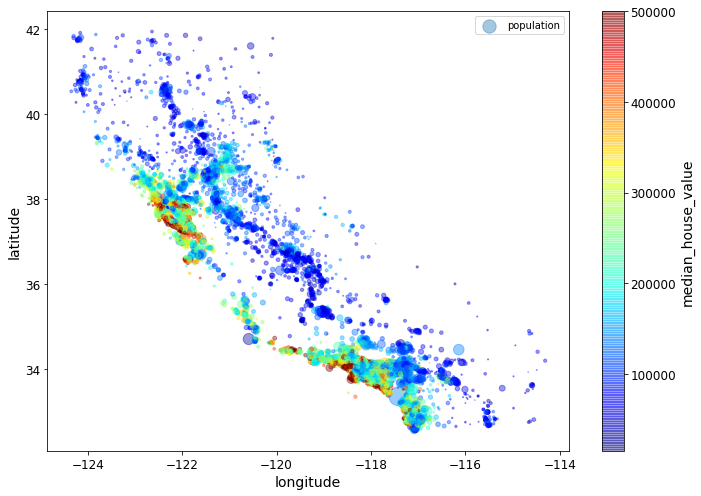

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7ff4cb017ad0>)

그림 저장: california_housing_prices_plot


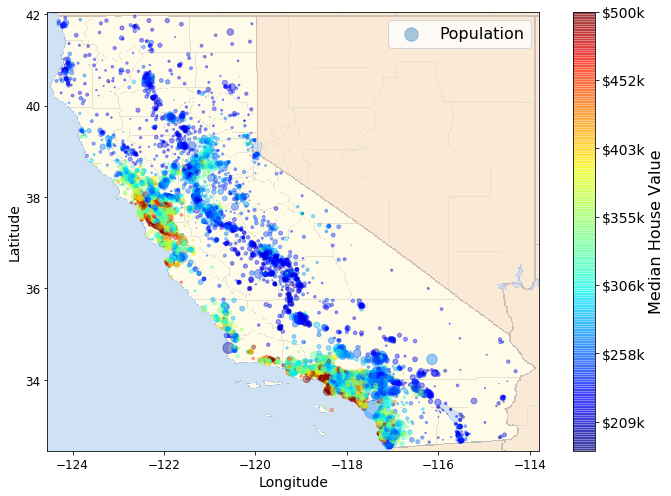

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

피어슨의 상관 계수(위키백과):
![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

그림 저장: scatter_matrix_plot


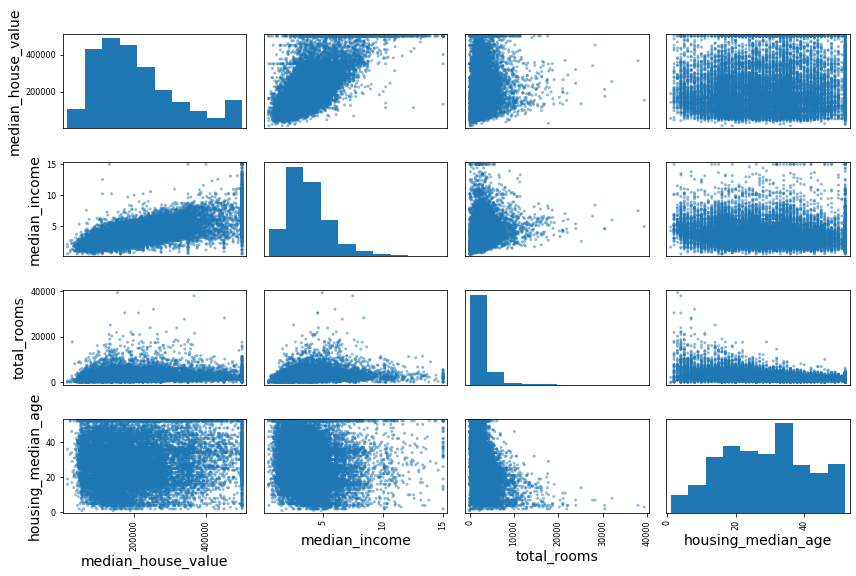

In [ ]:
# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

그림 저장: income_vs_house_value_scatterplot


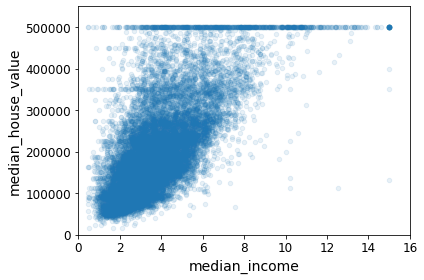

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

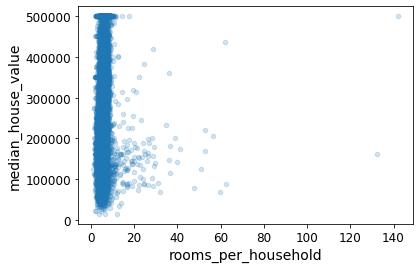

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

In [ ]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             5.440341           0.212878   
std         115703.014830             2.611712           0.057379   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442040           0.175304   
50%         179500.000000             5.232284           0.203031   
75%         263900.000000             6.056361           0.239831   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

# 머신러닝 알고리즘을 위한 데이터 준비

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

longitude  latitude  housing_median_age  total_rooms  population  \
4629     -118.30     34.07                18.0       3759.0      3296.0   
6068     -117.86     34.01                16.0       4632.0      3038.0   
17923    -121.97     37.35                30.0       1955.0       999.0   
13656    -117.30     34.05                 6.0       2155.0      1039.0   
19252    -122.79     38.48                 7.0       6837.0      3468.0   

       households  median_income ocean_proximity  
4629       1462.0         2.2708       <1H OCEAN  
6068        727.0         5.1762       <1H OCEAN  
17923       386.0         4.6328       <1H OCEAN  
13656       391.0         1.6675          INLAND  
19252      1405.0         3.1662       <1H OCEAN

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [ ]:
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

훈련 세트를 변환합니다:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662

In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29                 38        1568            351   
18632   -121.93    37.05                 14         679            108   
14650    -117.2    32.77                 31        1952            471   
3230    -119.61    36.31                 25        1847            371   
3555    -118.59    34.23                 17        6592           1525   

      population households median_income ocean_proximity rooms_per_household  \
17606        710        339        2.7042       <1H OCEAN             4.62537   
18632        306        113        6.4214       <1H OCEAN             6.00885   
14650        936        462        2.8621      NEAR OCEAN             4.22511   
3230        1460        353        1.8839          INLAND             5.23229   
3555        4459       1463        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                   2.0944  
18632                  2.70796  
14650                  2.02597  
3230                   4.13598  
3555                   3.04785

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 16)

다음은 (판다스 `DataFrame` 열의 일부를 선택하기 위해) `DataFrameSelector` 변환기와 `FeatureUnion`를 사용한 예전 방식입니다:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

`ColumnTransformer`의 결과와 동일합니다:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

True

# 모델 선택과 훈련

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


실제 값과 비교합니다:

In [ ]:
print("레이블:", list(some_labels))

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# 모델 세부 튜닝

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균: 71407.68766037929
표준 편차: 2439.4345041191004


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준 편차: 2731.674001798348


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준 편차: 2097.0810550985693


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 파라미터 조합은 다음과 같습니다:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.050877      0.001108         0.002517        0.000015   
1        0.164428      0.001815         0.007119        0.000019   
2        0.495403      0.004303         0.019859        0.000051   
3        0.084140      0.001059         0.002532        0.000008   
4        0.275067      0.001553         0.007142        0.000011   
5        0.819323      0.002004         0.019863        0.000012   
6        0.113894      0.003145         0.002529        0.000011   
7        0.379435      0.002942         0.007157        0.000031   
8        1.150662      0.005214         0.019885        0.000035   
9        0.145883      0.000841         0.002519        0.000015   
10       0.490615      0.003648         0.007134        0.000030   
11       1.482264      0.004879         0.019989        0.000157   
12       0.079072      0.001374         0.002938        0.000008   
13       0.262843      0.002048         0.008202        0.000027   
14       0.106422      0.002105         0.002971        0.000058   
15       0.349397      0.003296         0.008190        0.000026   
16       0.133129      0.002169         0.002928        0.000024   
17       0.439812      0.001434         0.008159        0.000031   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}      -3.837622e+09   
1             {'max_features': 2, 'n_estimators': 10}      -3.047771e+09   
2             {'max_features': 2, 'n_estimators': 30}      -2.689185e+09   
3              {'max_features': 4, 'n_estimators': 3}      -3.730181e+09   
4             {'max_features': 4, 'n_estimators': 10}      -2.666283e+09   
5             {'max_features': 4, 'n_estimators': 30}      -2.387153e+09   
6              {'max_features': 6, 'n_estimators': 3}      -3.119657e+09   
7             {'max_features': 6, 'n_estimators': 10}      -2.549663e+09   
8             {'max_features': 6, 'n_estimators': 30}      -2.370010e+09   
9              {'max_features': 8, 'n_estimators': 3}      -3.353504e+09   
10            {'max_features': 8, 'n_estimators': 10}      -2.571970e+09   
11            {'max_features': 8, 'n_estimators': 30}      -2.357390e+09   
12  {'bootstrap': False, 'max_features': 2, 'n_est...      -3.785816e+09   
13  {'bootstrap': False, 'max_features': 2, 'n_est...      -2.810721e+09   
14  {'bootstrap': False, 'max_features': 3, 'n_est...      -3.618324e+09   
15  {'bootstrap': False, 'max_features': 3, 'n_est...      -2.757999e+09   
16  {'bootstrap': False, 'max_features': 4, 'n_est...      -3.134040e+09   
17  {'bootstrap': False, 'max_features': 4, 'n_est...      -2.525578e+09   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0       -4.147108e+09  ...    -4.053756e+09  

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c8035550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c80358d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

다음과 같이 수동으로 계산할 수도 있습니다:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

또는 t-점수 대신 z-점수를 사용할 수도 있습니다:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# 추가 내용

## 전처리와 예측을 포함한 전체 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## joblib를 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

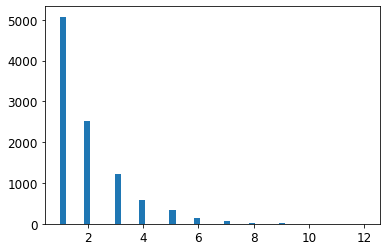

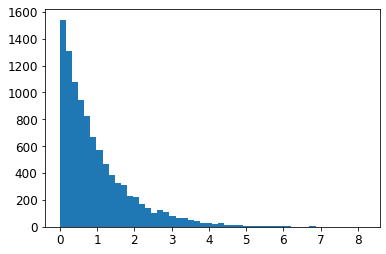

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# 연습문제 해답

## 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.9s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.7s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 44.3min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

## 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.2s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  51.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  56.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  44.5s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.3s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.5

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   6.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  36.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  35.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  56.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  37.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  30.7s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.6s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   

[CV]  C=6287.039489427172, gamma=0.3504567255332862, kernel=linear, total=   8.4s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  37.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  43.1s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  40.6s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  41.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  38.6s
[CV] C=926.9787684096649, gamma=2.147979593060577, kernel=rbf ........
[CV]  C=926.9787684096649, gamma=2.147979593060577, kernel=rbf, total=  10.6s
[CV] C=926.97876840

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 68.0min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4cb149b50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4ddacce10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084146

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

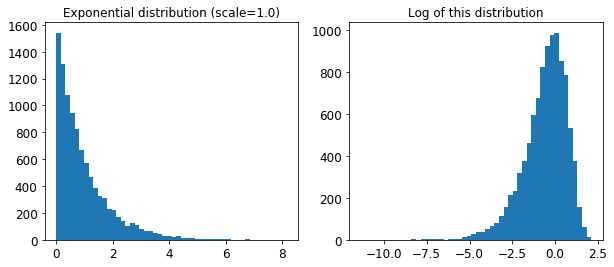

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 스케일이 정확이 무엇인지 모를 때 사용하면 좋습니다:

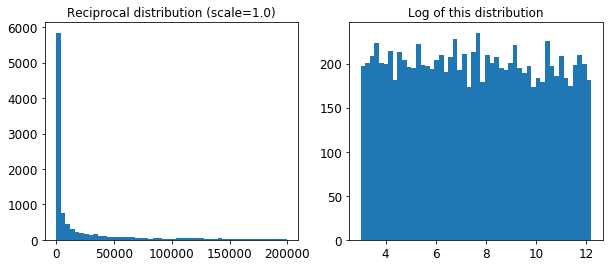

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 스케일을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

## 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [ ]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

성공입니다!  :)

## 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

## 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.7s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.2s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  10.5s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  23.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.9s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.2s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.1s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  25.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  27.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  24.7s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  25.9s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 68.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [ ]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.

축하합니다! 이제 머신러닝에 대해 꽤 많은 것을 알게 되었습니다. :)